In [1]:
%matplotlib inline
import sys
import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.sparse as ssp

hf.set_plot_defaults(fontsize=12)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures

### Load Data

In [2]:
adata = sc.read('210902_PATBROWN_final_subclustered_updated_vasc.h5ad')

In [3]:
# Normalize to CP10K for plotting
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

adata.raw = adata

In [4]:
# Isolate pericyte and endothelial populations
adata_peri_WT = adata[adata.obs['cell_type'].isin(['Pericytes WT'])]
adata_peri_mut = adata[adata.obs['cell_type'].isin(['Pericytes mut'])]
adata_endo_WT = adata[adata.obs['cell_type'].isin(['Endothelial WT'])]
adata_endo_mut = adata[adata.obs['cell_type'].isin(['Endothelial mut'])]

### Plot Pericyte Genes for WT and hm41 mutant line

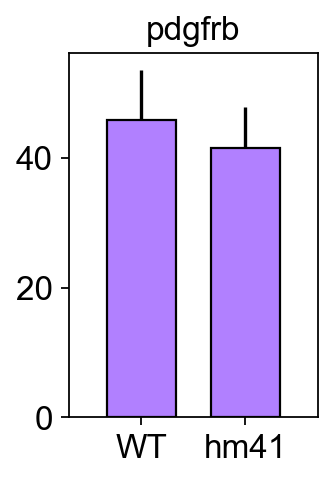

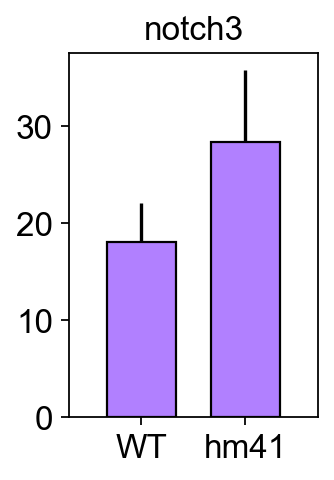

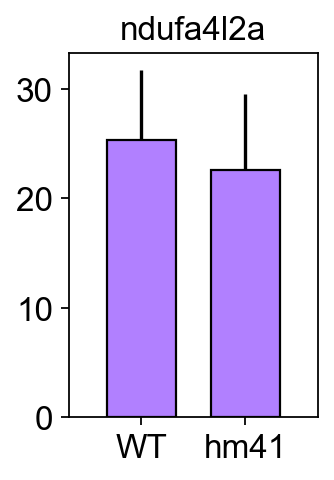

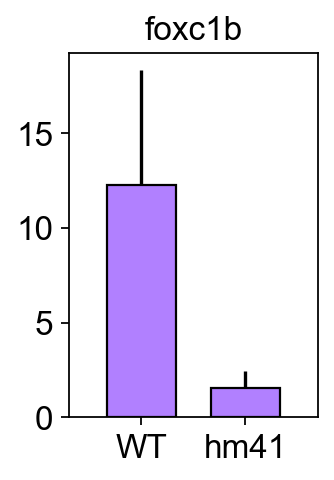

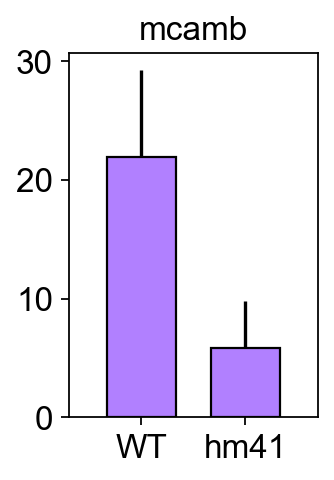

In [5]:
# genes to plot
gene_list = ['pdgfrb', 'notch3', 'ndufa4l2a', 'foxc1b', 'mcamb']


for i in gene_list:

    plt.figure(figsize=(2, 3), dpi=80)

    gene=i

    # Genotypes
    x = ['WT', 'hm41']

    # Gene expression for each cell
    exp1 = adata_peri_WT[:,gene].X.toarray()
    exp2 = adata_peri_mut[:,gene].X.toarray()
    
    # Mean and Standard deviation expression
    means = [exp1.mean(), exp2.mean()]
    sem = [(0,0), (exp1.std()/np.sqrt(len(exp1)), exp2.std()/np.sqrt(len(exp2)))]
    
    # Plot Data
    x_pos = [0, 1]

    plt.bar(x_pos, means, color='#B180FF', yerr=sem, width=0.67, ec='black')
    # plt.ylabel("mean-normalized expression")
    plt.title(gene, fontsize=15)

    plt.xticks(x_pos, x, fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    plt.xlim([-0.7,1.7])

    plt.savefig('barplots/pericyte_'+gene+'.pdf')
    plt.show()


### Plot Endothelial Genes

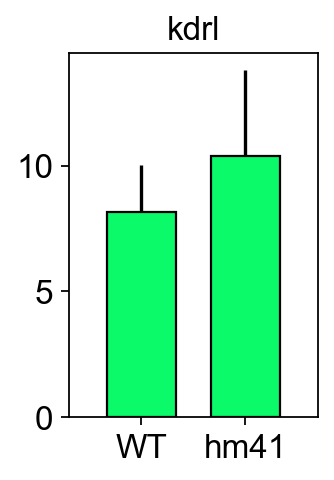

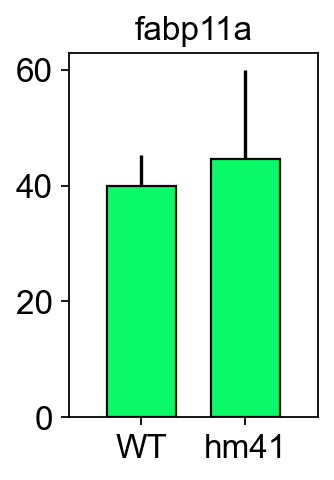

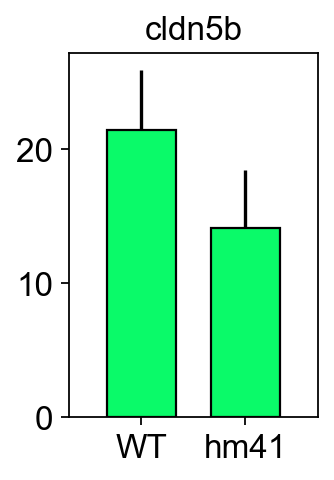

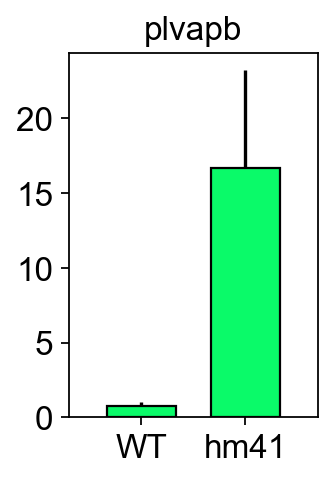

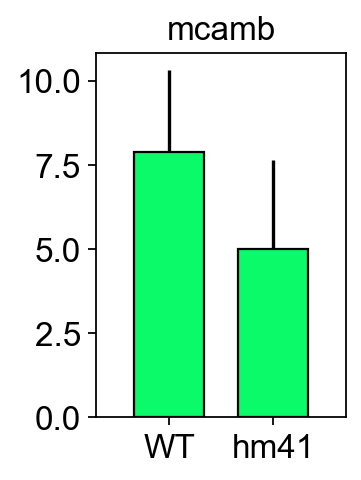

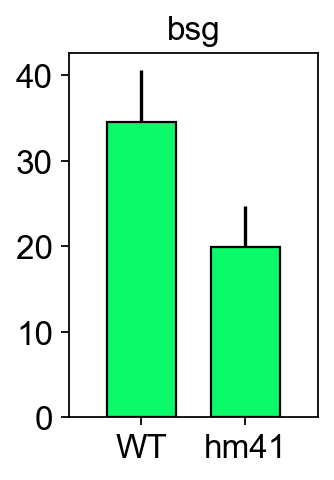

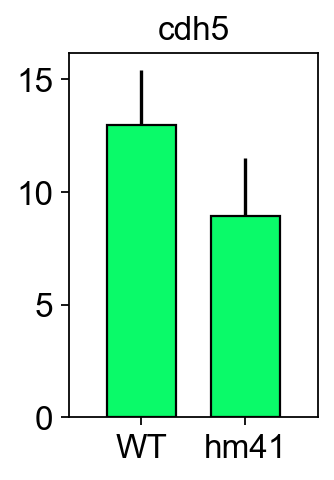

In [6]:
# genes to plot
gene_list = ['kdrl', 'fabp11a', 'cldn5b', 'plvapb', 'mcamb', 'bsg', 'cdh5']


for i in gene_list:

    plt.figure(figsize=(2, 3), dpi=80)

    gene=i

    # Genotypes
    x = ['WT', 'hm41']

    # Gene expression for each cell
    exp1 = adata_endo_WT[:,gene].X.toarray()
    exp2 = adata_endo_mut[:,gene].X.toarray()
    
    # Mean and Standard deviation expression
    means = [exp1.mean(), exp2.mean()]
    sem = [(0,0), (exp1.std()/np.sqrt(len(exp1)), exp2.std()/np.sqrt(len(exp2)))]
    
    # Plot Data
    x_pos = [0, 1]

    plt.bar(x_pos, means, color='#0AFA69', yerr=sem, width=0.67, ec='black')
    # plt.ylabel("mean-normalized expression")
    plt.title(gene, fontsize=15)

    plt.xticks(x_pos, x, fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    plt.xlim([-0.7,1.7])


    plt.savefig('barplots/endothelial_'+gene+'.pdf')
    plt.show()

### Perform DGE by Genotype and Leiden Cluster

In [7]:
# Rank sum test

def get_dge(ad, mask1, mask2, min_frac_expr=0.05, pseudocount=1):
    import statsmodels.sandbox.stats.multicomp
    import scipy.stats
    
    gene_mask = ((ad.X[mask1,:]>0).sum(0).A.squeeze()/mask1.sum() > min_frac_expr) | ((ad.X[mask2,:]>0).sum(0).A.squeeze()/mask2.sum() > min_frac_expr)
    print(sum(gene_mask))
    
    E1 = ad.X[mask1,:][:,gene_mask].toarray()
    E2 = ad.X[mask2,:][:,gene_mask].toarray()
    
    m1 = E1.mean(0) + pseudocount
    m2 = E2.mean(0) + pseudocount
    r = np.log2(m1 / m2)
    
    pv = np.zeros(gene_mask.sum())
    for ii,iG in enumerate(np.nonzero(gene_mask)[0]):
        pv[ii] = scipy.stats.ranksums(E1[:,ii], E2[:,ii])[1]
    pv = statsmodels.sandbox.stats.multicomp.multipletests(pv, alpha=0.05, method='fdr_bh',)[1]
    
    df = pd.DataFrame({
        'gene': ad.var_names.values.astype(str)[gene_mask],
        'p-value': pv,
        'm1': m1 - pseudocount, 
        'm2': m2 - pseudocount, 
        'ratio': r
    })
    
    return df

In [8]:
# Treat RNF and AB as same genotype
mask = adata.obs['genotype']=='RNF'
adata.obs.loc[mask,'genotype']='AB'
adata.obs['genotype'].unique()

['mutSpock1', 'AB']
Categories (3, object): ['AB', 'RNF', 'mutSpock1']

In [9]:
# Prepare clusters to loop over
adata.obs['leiden']=adata.obs['leiden'].astype(str)

leiden_vals = adata.obs['leiden'].unique()

In [10]:
# For each cluster, perform rank sum test
# Minimum expression 5% Cells
# Threshold of 20 average transcripts
# Absolute fold change > 2
# Export to excel


# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('DGE_Output_final/SUBCLUSTERED_vasc_DGE_genes_per_leiden.xlsx', engine='xlsxwriter')


for i in leiden_vals:
    cluster = str(i)
    
    # Mask cells to compare
    mask1 = (adata.obs['genotype']=='mutSpock1') & (adata.obs['leiden']==cluster)
    mask2 = (adata.obs['genotype']=='AB') & (adata.obs['leiden']==cluster)
    
    # DGE Analysis
    df = get_dge(adata,mask1,mask2)
    
    # Thresholding Genes
    threshold = ((df.m1>10) | (df.m2>10)) & (abs(df.ratio)>1)
    df = df[threshold]

    df = df.rename(columns={'m1': 'hm41 (CP10K)', 'm2': 'WT (CP10K)', 'ratio': 'log2 ratio (pseudocount=1)'})
    
    # Export to worksheet
    df.to_excel(writer, sheet_name='Leiden ' + cluster)

    
# Close the Pandas Excel writer and output the Excel file.
writer.save()

4792
5557
5150
5978
4519
4717
6844
6418
7521
7539
7485
7293
8234
6431
5342


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice.
  del sys.path[0]
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:7103: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


6184
